In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import keras

import librosa

/Users/shohei/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
sampling_rate = 16000
raw_sounds = []
wav_file_names = []

path = 'data/*.mp3'

for wav_file_name in sorted(glob.glob(path)):
    data, sample_rate = librosa.load(wav_file_name,
                                     sr=sampling_rate,
                                     duration=30)
    print('{} ({} Hz) '.format(wav_file_name, sample_rate))
    raw_sounds.append(data)
    wav_file_names.append(wav_file_name)

data/background.mp3 (16000 Hz) 
data/cuttin_in_focus.mp3 (16000 Hz) 
data/cutting_out_focus.mp3 (16000 Hz) 
data/engraving.mp3 (16000 Hz) 
data/sleeping.mp3 (16000 Hz) 
data/waiting.mp3 (16000 Hz) 


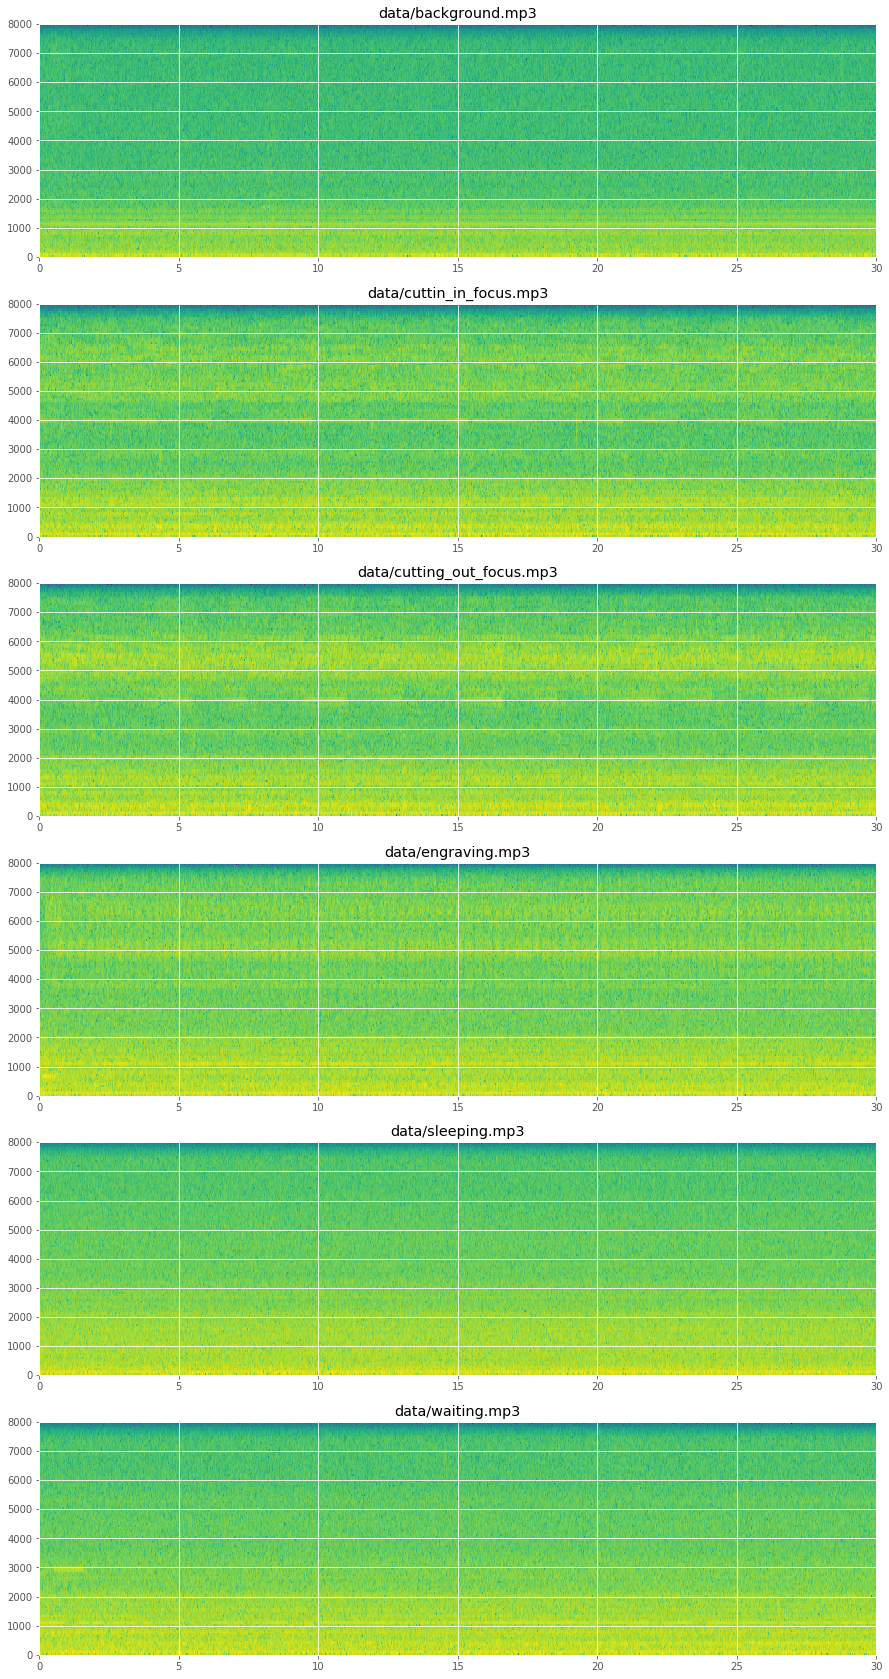

In [4]:
fig = plt.figure(figsize=(15, 5 * len(wav_file_names)))

for i, wav_file_name in enumerate(wav_file_names):
    plt.subplot(len(wav_file_names), 1, 1 + i)
    plt.specgram(np.array(raw_sounds[i]), Fs=sampling_rate)
    plt.title(wav_file_name)

plt.show()

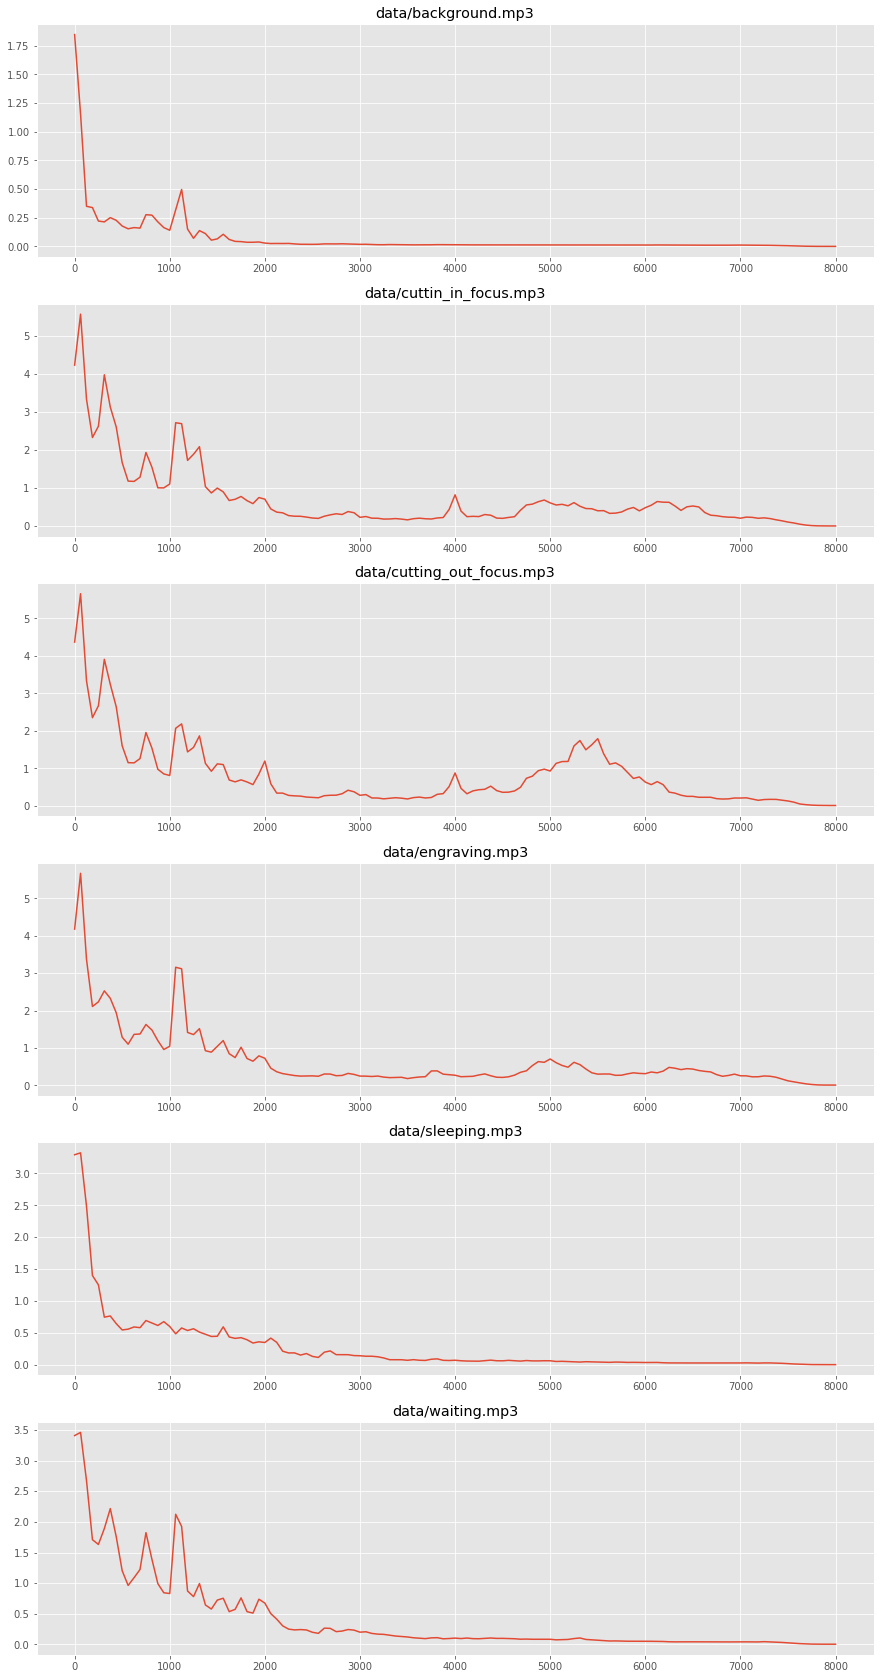

In [5]:
fft_size = 256
stft_matrix_size = 1 + fft_size // 2

X = np.empty((0, stft_matrix_size))
y = np.empty(0)

fig = plt.figure(figsize=(15, 5 * len(wav_file_names)))

for i, wav_file_name in enumerate(wav_file_names):
    d = np.abs(librosa.stft(raw_sounds[i], n_fft=fft_size, window='hamming'))
    X = np.vstack([X, d.transpose()])
    y = np.hstack([y, [i] * d.shape[1]])
    plt.subplot(len(wav_file_names), 1, 1 + i)
    plt.plot(librosa.fft_frequencies(sr=sampling_rate, n_fft=fft_size),
             np.mean(d, axis=1))
    plt.title(wav_file_name)

plt.show()


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(128, activation='sigmoid', input_dim=stft_matrix_size))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(len(wav_file_names), activation='softmax'))
model.compile(Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
from sklearn.model_selection import train_test_split

y_cat = keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)

from keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_acc',
                            patience=2,
                            verbose=True,
                            mode='auto')

model.fit(X_train, y_train, epochs=20, batch_size=32,
          validation_split=0.2, callbacks=[es_callback])

Train on 28803 samples, validate on 7201 samples
Epoch 1/20
28803/28803 [==============================] - 1s - loss: 0.1366 - acc: 0.9517 - val_loss: 0.1089 - val_acc: 0.9615
Epoch 2/20
28803/28803 [==============================] - 1s - loss: 0.0623 - acc: 0.9774 - val_loss: 0.0453 - val_acc: 0.9858
Epoch 3/20
28803/28803 [==============================] - 1s - loss: 0.0531 - acc: 0.9803 - val_loss: 0.0544 - val_acc: 0.9797
Epoch 4/20
28803/28803 [==============================] - 1s - loss: 0.0494 - acc: 0.9815 - val_loss: 0.0376 - val_acc: 0.9858
Epoch 5/20
28803/28803 [==============================] - 1s - loss: 0.0515 - acc: 0.9804 - val_loss: 0.0549 - val_acc: 0.9765
Epoch 00004: early stopping


In [8]:
model.evaluate(X_test, y_test)

7136/9002 [======================>.......] - ETA: 0s

[0.06756973947185035, 0.9714507886871341]

In [9]:
y_test

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [10]:
model.save('laser_machine.h5')

In [11]:
import numpy as np
import keras
import librosa

model = keras.models.load_model('laser_machine.h5')
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 25,286
Trainable params: 25,286
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
import numpy as np
import keras
import librosa
import pyaudio
import time

In [13]:
STATES = ['Background',
          'Cutting in focus',
          'Cutting out focus',
          'Marking',
          'Sleeping',
          'Waiting',
          'Unknown']

last_state = STATES.index('Unknown')

SAMPLING_RATE = 16000
CHUNK = 1 * SAMPLING_RATE
FFT_SIZE = 256
THRESHOLD = 0.8

audio_interface = pyaudio.PyAudio()
audio_stream = audio_interface.open(format=pyaudio.paInt16,
                                    channels=1,
                                    rate=SAMPLING_RATE,
                                    input=True,
                                    frames_per_buffer=CHUNK,
                                    start=False)

audio_stream.start_stream()

try:
    while True:
        data = np.frombuffer(audio_stream.read(CHUNK),
                            dtype=np.int16).astype(float)
        # Pause the audio stream
        audio_stream.stop_stream()

        start = time.time()

        state = last_state

        D = librosa.stft(librosa.util.normalize(data),
                         n_fft=FFT_SIZE,
                         window='hamming')
        magnitude = np.abs(D)
        predictions = model.predict_proba(magnitude.transpose(),
                                          verbose=False)
        predictions_mean = predictions.mean(axis=0)

        elapsed_time = time.time() - start

        print('{0:s} ({1:.3f}, processed in {2:.3f} seconds)'.format(
            STATES[predictions_mean.argmax()],
            predictions_mean.max(),
            elapsed_time))

        if predictions_mean.max() > THRESHOLD:
            state = predictions_mean.argmax()

        if last_state != state:
            print('CHANGED: {0} > {1}'.format(
                STATES[last_state], STATES[state]))
            last_state = state

        # Resume the audio stream
        audio_stream.start_stream()

except KeyboardInterrupt:
    print('Requested to terminate')

finally:
    audio_stream.stop_stream()
    audio_stream.close()
    audio_interface.terminate()
    print('Terminated')

Background (0.950, processed in 0.031 seconds)
CHANGED: Unknown > Background
Sleeping (0.311, processed in 0.006 seconds)
Marking (0.441, processed in 0.006 seconds)
Marking (0.360, processed in 0.008 seconds)
Marking (0.396, processed in 0.007 seconds)
Requested to terminate
Terminated
